# Modern Portfolio Theory
In this notebook I will explore the Markowitz style optimal portfolio (based on mean return and mean covariance)

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

from scipy.optimize import minimize

%matplotlib inline

## General Framework

* Add some generic BLAH BLAH regarding assumptions, etc.

Use that to motivate calculation of portfolio returns and volatility.


In [242]:
def portfolio_return(weights, returns):
    return np.sum(weights*returns)

def portfolio_volatility(weights, cov):
    return np.sqrt(weights.T@cov@weights)

def sharpe_ratio(weights, returns, cov, riskfree_rate):
    sr = (portfolio_return(weights, returns)-riskfree_rate) / portfolio_volatility(weights,cov)
    return sr

## Two Asset Portfolio
As a warm-up, we begin with a portfolio of two risky assets.
This is useful, since we can derive analytic results and build some
intuition for the dependence of the the optimal portfolio the returns
and covariances.

Let's denote the returns of the portfolio by $r_i$ and the corresponding covariance matrix by  
$$C_{ij} \equiv \left\langle  \right\rangle $$

Denote the weights in the two assets by $w_i$.  Since there are only two assets, we have the constraint $w_2 = 1-w_1$, we the properties of the portfolio depend only on the single paramter $w_1$.

We invest in each of the risky assets with weight
$$ w_i = \frac{V_i}{V_0} $$
where $V_i$ is the value of asset $i$ in the portfolio at time $t=0$, and $V_0$ is the total portfolio value.
Obviously, we have
$$ \sum_i w_i = 1 $$
and to avoid taking short positions or adding leverage, we will assume
$$ 0\leq w_i \leq 1 \qquad \forall i\in\{1,2,\dots,N\}$$
The value of the portfolio with initial value $V_0$ invested with weights $w_i$ in asset $i$ is  
$$ V_0(1+R_{\rm p}) = V_0\sum_i w_i(1+r_i) $$
so the return of the portfolio is
$$ R_{\rm p} = w_ir_i $$
Meanwhile, the square of the portfolio volatility is  
$$ \sigma_{\rm p}^2 = \sum_{ij} w_iw_j\sigma_{ij} = w_1^2\sigma_1^2 + w_2^2\sigma_2^2 + 2w_1w_2\sigma_1\sigma_2\rho_{12} $$
where  
$$ \rho_{ij} = \frac{C_{ij}}{\sqrt{C_{ii}C_{jj}}} $$
is the correlation between the assets.

For the two asset portfolio, we can also analytically determine both the Sharpe ratio and the minimum variance portfolio.  The equal weight portfolio, is of course trivial to obtain.

It is easier to minimize the squared volatility
$$ \frac{\partial\sigma^2}{\partial w_1} = 2\left[w_1\sigma^2_1 - (1-w_1)\sigma^2_2 + (1-2w_1)\sigma_1\sigma_2\rho \right]= 0$$

Finally, to get the maximum Sharpe ratio portfolio, we use
$$ (r_1-r_2)/\sigma_p - (w_1r_1 + r_2-w_2r_2-r_0)/\sigma_p^2 $$

In [80]:
def portfolio_returns_and_vol_two_asset(asset_returns, covariances, n_points=101):
    """
    Returns the efficient frontier for a portfolio of two assets
    """
    w1 = np.linspace(0.,1.,n_points)
    weights = np.array([ [w_,1.-w_] for w_ in w1])
    
    log_ret = np.log1p(asset_returns)
    
    portfolio_return = np.empty(w1.size)
    portfolio_vol = np.empty(w1.size)
    
    for i,w_ in enumerate(weights):
        portfolio_return[i] = np.sum(w_*asset_returns) # Fix this
        portfolio_vol[i] = np.sqrt(w_@covariances@w_.T)   # Check this
    
    return portfolio_return, portfolio_vol, w1

In [45]:
def maximum_sharpe_ratio_portfolio_two_asset(asset_returns, cov, riskfree_rate):
    return 

In [77]:
def equal_weight_portfolio_two_asset(asset_returns, cov):
    w = np.array([0.5,0.5])
    return np.sum(w*asset_returns), np.sqrt(w.T@cov@w), 0.5

In [99]:
def minimum_volatility_portfolio_two_asset(returns, cov):
    w1 = (cov[1,1] - cov[0,1]) / (cov[0,0] + cov[1,1] - 2.*cov[0,1])
    # w1 * ln det(cov) = sigma^2_2- sigma_1\sigma_2\rho
    weights = np.array([w1,1.-w1])
    ret = portfolio_return(weights, returns)
    vol = portfolio_volatility(weights, cov)
    return  ret, vol, w1

In [140]:
def plot_two_asset_frontier(rets, cov, riskfree_rate=0.01):
    """
    Plot the possible portfolio returns for a two-asset portfolio.
    """
    f,a = plt.subplots()
    
    r,v,_ = portfolio_returns_and_vol_two_asset(rets,cov)
    a.plot(v,r)
    
    r,v,_ = equal_weight_portfolio_two_asset(rets,cov)
    a.scatter(v,r, color='goldenrod', label='Eq. Weight')
    
    r,v,_ = minimum_volatility_portfolio_two_asset(rets, cov)
    a.scatter(v,r,color='indianred', label='Min. Vol.')
    
    r,v,_ = maximum_sharpe_ratio_portfolio(rets,cov,riskfree_rate)
    a.scatter(v,r,color='midnightblue', label='Max. Sharpe')
    #a.plot([0.,v],[riskfree_rate,r],'--',color='midnightblue')
    
    a.set_xlabel(r'$\sigma_{\rm p}$')
    a.set_ylabel(r'$R_{\rm p}$')
    
    a.legend(loc='lower right')

In [147]:
rets = np.array([0.07,0.09])
cov = np.array([[0.04,0.0005],[0.0005,0.06]])

In [128]:
v,r,_ = portfolio_returns_and_vol_two_asset(rets,cov)

-0.44052174286928686


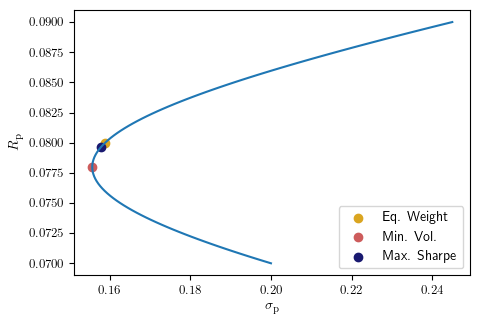

In [148]:
plot_two_asset_frontier(rets,cov,riskfree_rate=0.02)

## MultiAsset Portfolios
We now have to solve numerically for the efficient frontier

In [184]:
def minimize_volatility(target_return, rets, cov, guess=None):
    n_assets = len(rets)
    
    if guess is not None:
        init_guess = guess
    else:
        init_guess = np.repeat(1./n_assets,n_assets)
        
    bounds = ((0.,1.),)*n_assets
    weight_sum = {'type' : 'eq',
                  'fun' : lambda w : np.sum(w)-1.}
    return_sum = {'type' : 'eq',
                  'fun' : lambda w : np.sum(w*rets)-target_return}
    
    # Do this, or the square, or something else?
    def vol(w,cov):
        return np.sqrt(w.T@cov@w)
    
    results = minimize(vol, init_guess,
                      args=(cov,),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=[weight_sum, return_sum],
                      options={'disp':False},
                      tol=1.e-8)
    
    weights = results.x
    
    return weights

In [190]:
def efficient_portfolio_returns_and_vol(asset_returns, cov):
    n_assets = len(asset_returns)
    
    r_min = np.min(asset_returns)
    r_max = np.max(asset_returns)
    w_min = np.zeros(n_assets)
    w_min[np.argmin(asset_returns)] = 1.
    w_max = np.zeros(n_assets)
    w_max[np.argmax(asset_returns)] = 1.
    
    rets = np.linspace(r_min, r_max, 101)
    vols = []
    
    w_cur = w_min
    for r_ in rets:
        w_cur = minimize_volatility(r_, asset_returns, cov, guess=w_cur)
        vols.append(portfolio_volatility(w_cur,cov))
    
    return rets, np.array(vols)

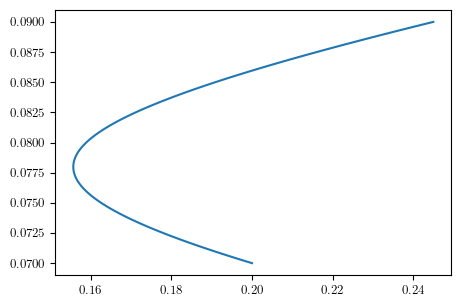

In [191]:
np.min(rets)
r,v = efficient_portfolio_returns_and_vol(rets,cov)
plt.plot(v,r)

In [256]:
def plot_efficient_frontier(asset_returns, covariance, riskfree_rate, n_samples=1000):
    fig,ax = plt.subplots()
    n_assets = len(asset_returns)
    
    # 1. Numerically determine the efficient frontier
    r,v = efficient_portfolio_returns_and_vol(rets, cov)
    ax.plot(v,r)
    # 2. Randomly sample weights, make scatter plot colored by Sharpe ratio
    if n_samples > 0:
        r_samp, v_samp, sr = [], [], []
        w = np.random.uniform(low=0.,high=1.,size=(n_samples,n_assets))
        for w_ in w:
            weights = w_ / np.sum(w_)
            r_samp.append(portfolio_return(weights,asset_returns))
            v_samp.append(portfolio_volatility(weights,cov))
            sr.append(sharpe_ratio(weights,asset_returns,cov,riskfree_rate))
        ax.scatter(v_samp,r_samp,c=sr,alpha=0.2)
    
    
    # 3. Add MSR, MV and EW portfolios
    r_msr,v_msr,_ = maximum_sharpe_ratio_portfolio(asset_returns, covariance, riskfree_rate)
    ax.scatter(v_msr,r_msr,color='indianred',label='Max. Sharpe')
    
    w_ew = np.repeat(1./n_assets,n_assets)
    r_ew = portfolio_return(w,asset_returns)
    v_ew = portfolio_volatility(w,covariance)
    ax.scatter(v_ew,r_ew,color='goldenrod',label='Eq. Weight')
    
    #r_mv, v_mv, _ = minimum_volatility_portfolio(asset_returns, cov)
    
    # 4. Add capital market line
    
    ax.legend(loc='lower right')
    
    ax.set_xlabel(r'$\sigma_{\rm p}$')
    ax.set_ylabel(r'$R_{\rm p}$')
    return

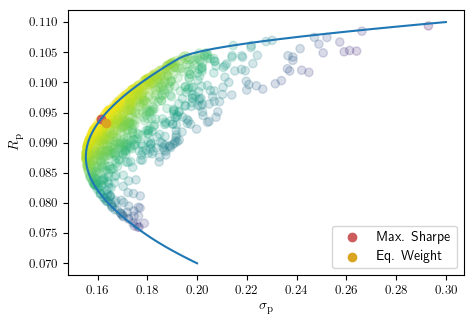

In [257]:
rets = np.array([0.07,0.10,0.11])
cov = np.array([[0.04,0.01,0.01],
                [0.01,0.05,0.01],
                [0.01,0.01,0.09]])
plot_efficient_frontier(rets,cov,0.01,n_samples=1000)

In [ ]:
# Add here : Distribution of returns with simulated portfolios 
#  using the Geometric Brownian Motion approximation (the approx. in the construction)

# Compare using historical estimates for vol with subsequent returns
# Use historical data to make plots over time (at fixed rolling window)
# Animate this plot (or have sliders for window and time)
#
# Do some runs with non GBM to see how bad it is

In [233]:
def maximum_sharpe_ratio_portfolio(rets, cov, riskfree_rate, guess=None):
    n_assets = len(rets)
    
    if guess:
        init_guess = guess
    else:
        init_guess = np.repeat(1./n_assets,n_assets)
    
    bounds = ((0.,1.),)*n_assets
    weight_sum = {'type' : 'eq',
                  'fun' : lambda w : np.sum(w)-1.}
    
    def neg_sharpe_ratio(w, rets, cov, rf):
        ret = np.sum(w*rets)
        vol = np.sqrt(w.T@cov@w)
        return (rf-ret)/vol
    
    results = minimize(neg_sharpe_ratio, init_guess,
                       args=(rets, cov, riskfree_rate),
                       method='SLSQP',
                       bounds=bounds,
                       constraints=[weight_sum],
                       options={'disp':False},
                       tol=1.e-8
                      )
    
    if not results.success:
        print(f"Failed to converge for risk free rate of {riskfree_rate}")
        
    weights = results.x
    ret = portfolio_return(weights, rets)
    vol = portfolio_volatility(weights, cov)
    
    return ret, vol, weights

In [258]:
def minimum_volatility_portfolio(rets, cov):
    return

In [259]:
def equal_weight_portfolio(rets, cov):
    n_assets = len(rets)
    weights = np.repeat(1./n_assets,n_assets)
    
    ret = portfolio_return(weights, rets)
    vol = portfolio_volatility(weights, cov)
    
    return ret, vol, weights

## Distribution of Returns from Idealised Simulations
The optimal portfolio construction outlined above assumes that the asset returns were completely characterised by their mean and volatility.  For the moment, let's ignore the issues of how one can forecast these parameters for real world assets, and assume that we know what their values will be in the future.  Let's also ignore any nonGaussianity in the log returns.

In this simplified scenario, we can easily simulate asset returns under the assumptions made by the optimal portfolio analysis.  This allows us to determine the distribution of returns we may expect from various strategies, even in this simplified case.

This analysis is not meant to be realistic, as real-world asset returns have significant nonGaussianity (especially in the tails).  As well, the expected returns and covariance matrix are nontrivial to forecast, and are presumably heteroscedastic.  However, it does give us a baseline estimate of the amount of statistical fluctuation we expect by investing in various portfolios.

## Simulating Geometric Brownian Motion
As with the entire analysis, this is not meant to be an optimal way to simulate Geometric Brownian Motion.  I leave an investigation of various discretisation schemes, and how the parameters in them are related to each other, to future work.

In [ ]:
def simulate_asset_returns(n_samples, n_steps, returns, covariance):
    n_assets = len(returns)
    
    # 1. Generate correlated Gaussian random deviates
    #
    # 2. Given the xi noise terms, do the cumsum and product to get the price
    #
    # 3. Given these trajectories, and a set of weights, we can compute
    #    the return, volatility, and Sharpe ratio of the portfolio